<div class="warning" style='background-color:#15DB69; color:#000000; border-left: solid #004C23 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'>
<b>Projet Empow'her - exploration des données INSEP</b></p>
<p style='margin-left:1em;'>
Bonjour et bienvenu à cet atelier datacraft en collaboration avec l'INSEP.<br><br>
    
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'> <b>- L'équipe datacraft</b> <i>(pour l'atelier INSEP du 14 avril 2022)</i>
</p></span>
</div>

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as clrs

from sklearn import preprocessing #ajout du numéro 

import time
import os

%run utils.ipynb

%matplotlib inline

In [3]:
# !pip install tensorflow_probability==0.12.1

import tensorflow_probability as tfp
from tensorflow import keras

---

Chargement des jeux de données
---

In [4]:
t_start = time.time()

df_ath1 = pd.read_pickle("/workspace/data/df_ath1_full.pkl")
df_ath2 = pd.read_pickle("/workspace/data/df_ath2_full.pkl")

df_morning_ath1 = pd.read_pickle("/workspace/data/df_ath1_morning.pkl")
df_morning_ath2 = pd.read_pickle("/workspace/data/df_ath2_morning.pkl")

print(f"Time taken: {time.time()-t_start}")

Time taken: 1.1226959228515625


In [88]:
df = df_ath1

df = df.interpolate()
df["mask"] = 1.0

cols = ["heart_rate", "power_watts", "temperature"]

mean = df[cols].mean()
std = df[cols].std()
df = [(y - mean) / std for x, y in df[cols + ["training_counter"]].groupby('training_counter', as_index=False)]
# average every 10 seconds
df = [x.groupby(np.arange(len(x))//10).mean() for x in df]

ts_len = [x.shape[0] for x in df]

X = [np.array(x[cols[1:]], dtype="float32") for x in df]
Y = [np.array(x[cols[0:1]], dtype="float32") for x in df]
Y = [np.hstack([y, np.ones_like(y)]) for y in Y]

X = keras.preprocessing.sequence.pad_sequences(X, dtype='float32', maxlen = 1000)
Y = keras.preprocessing.sequence.pad_sequences(Y, dtype = "float32", maxlen = 1000)

In [78]:
n_params = tfp.layers.IndependentNormal.params_size(1)

model = keras.Sequential([
    keras.Input((None, 2)),
    keras.layers.GRU(8, return_sequences = True),
    keras.layers.Conv1D(n_params, 1),
    tfp.layers.IndependentNormal(1)
])

def loss_mll(y, distr):
    return -distr.log_prob(y[:,:,0:1]) * y[:,:,1]

model.compile(keras.optimizers.Adam(0.001), loss=loss_mll)

In [79]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, None, 8)           288       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 2)           18        
_________________________________________________________________
independent_normal_5 (Indepe multiple                  0         
Total params: 306
Trainable params: 306
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.fit(X, Y, epochs=10, validation_split = 0.3, batch_size = 10)

Epoch 1/10
11/11 [==============================] - 25s 2s/step - loss: 0.2924 - val_loss: 1.2237
Epoch 2/10
11/11 [==============================] - 16s 1s/step - loss: 0.2866 - val_loss: 1.2815
Epoch 3/10
 2/11 [====>.........................] - ETA: 11s - loss: 0.2819

KeyboardInterrupt: 

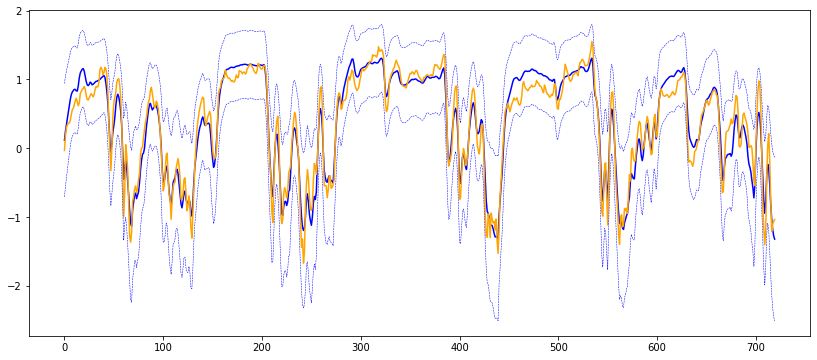

In [160]:
# idx = 34 # pics bizarres non anticipés
# idx = 114 # série très courte
# idx = 139 # valeurs manquantes mal prises en compte
# idx = 92 # donnée abbérante dans les puissances
idx = 10
distr = model(X[idx:(idx+1)])

pred_mean = distr.mean().numpy()[0, -ts_len[idx]:, 0]
pred_std = distr.stddev().numpy()[0, -ts_len[idx]:, 0]

plt.subplots(1, 1, figsize=(14, 6));
plt.plot(pred_mean, "b")
plt.plot(Y[idx, Y[idx, :, 1] == 1, 0], "orange")
plt.plot(pred_mean + 2 * pred_std, "b--", linewidth=0.5)
plt.plot(pred_mean - 2 * pred_std, "b--", linewidth=0.5)


In [101]:
distr = model(X)

log_probs = distr.log_prob(Y[:, :, 0:1])
mean_log_probs = np.sum(log_probs, axis=1) / ts_len


In [158]:
temp = mean_log_probs.argsort()
ranks = np.arange(len(temp))[temp.argsort()]
idx = np.where(ranks == 20)[0][0]
print(idx)

50


In [144]:
idx[0]

34

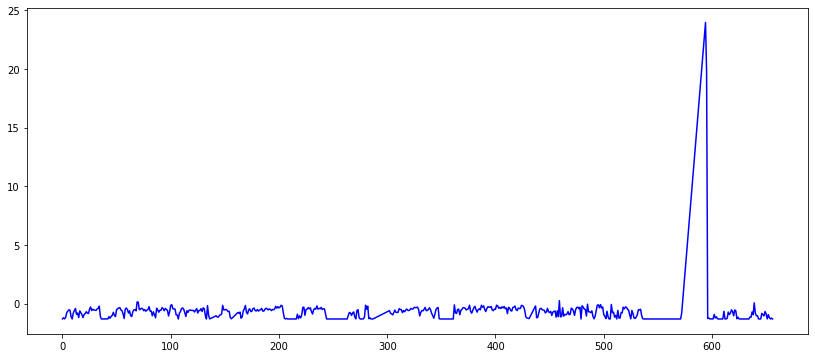

In [153]:
plt.subplots(1, 1, figsize=(14, 6));
plt.plot(X[idx, -ts_len[idx]:, 0], "b")

73370    endurance
Name: type_ent, dtype: object


<AxesSubplot:>

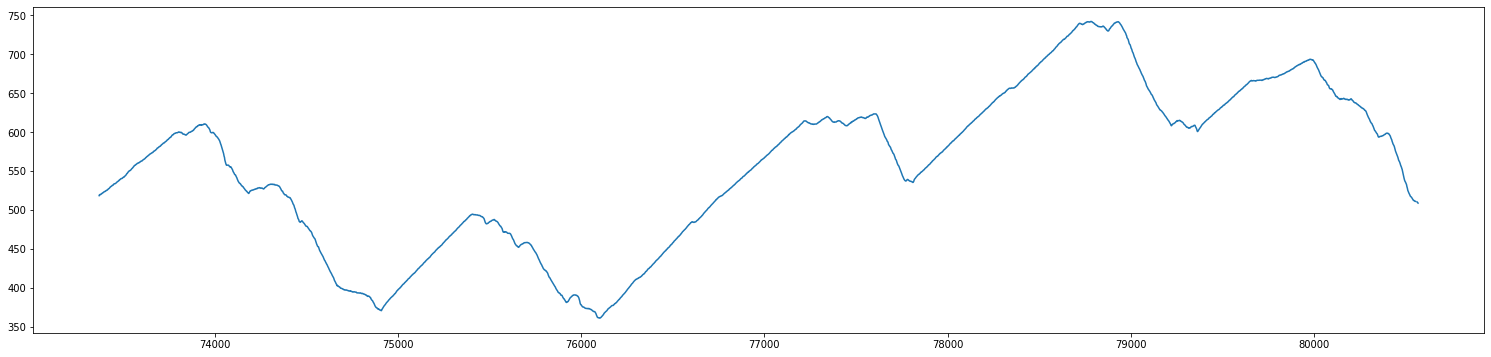

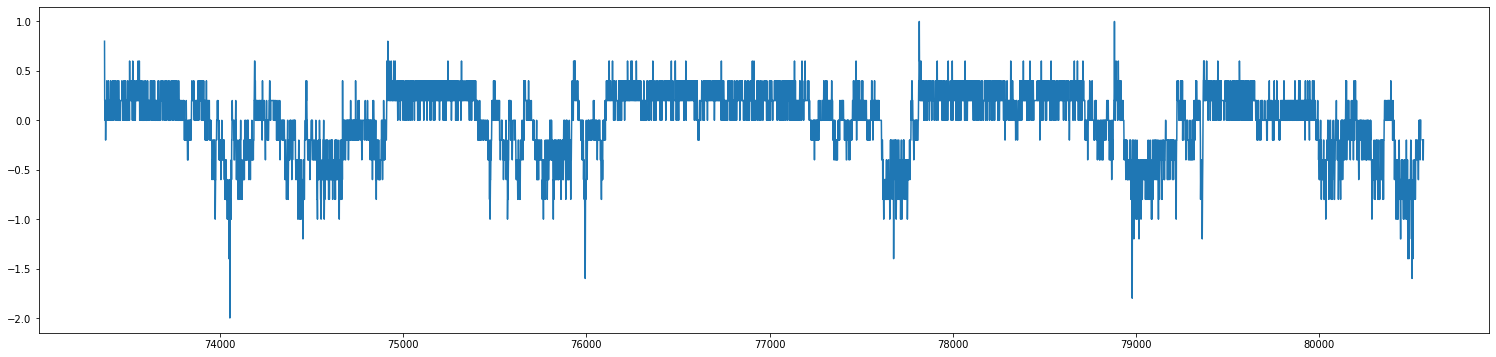

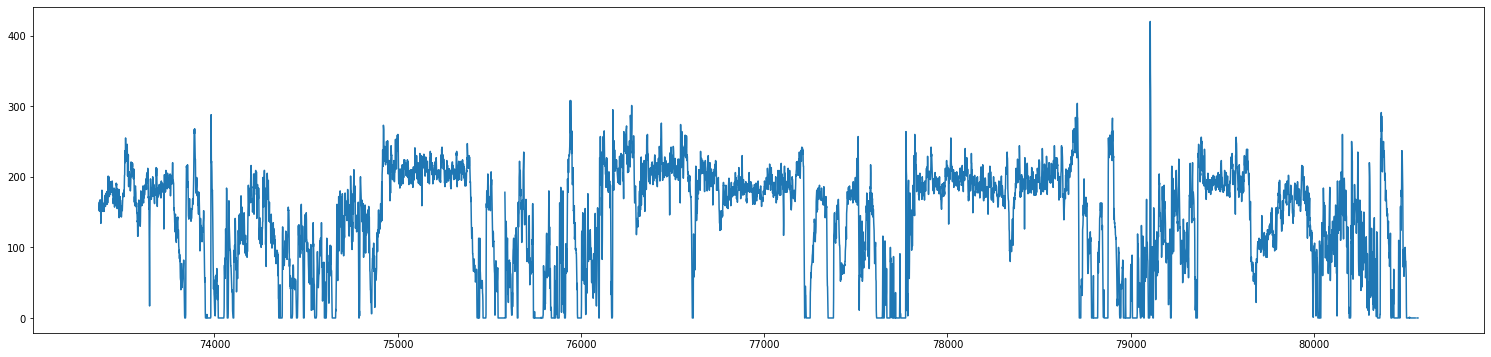

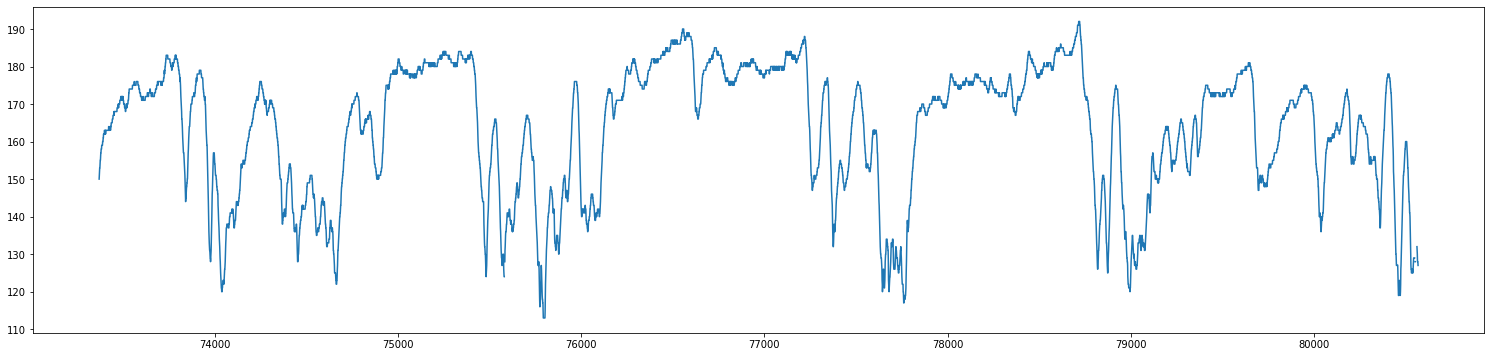

In [162]:
train_id = 11
train_data = df_ath1[df_ath1.training_counter == train_id]
print(train_data.type_ent[0:1])

plt.subplots(1, 1, figsize=(26, 6));
train_data.altitude.plot()

plt.subplots(1, 1, figsize=(26, 6));
train_data.altitude.diff().plot()

plt.subplots(1, 1, figsize=(26, 6));
train_data.power_watts.plot()

plt.subplots(1, 1, figsize=(26, 6));
train_data.heart_rate.plot()


In [21]:
df_ath1.altitude

0          800.6
1          801.0
2          800.8
3          800.8
4          800.8
           ...  
1040071    551.4
1040072    551.2
1040073    551.0
1040074    550.8
1040075    550.8
Name: altitude, Length: 1040076, dtype: float64

In [31]:
df_morning_ath1.head()

,date,about,heure_couche,heure_leve,nb_heure_sommeil,qualite_sommeil,ressentit_global,ressentit_emotion,symptomes,poids,blessures_douleurs,zone_de_douleur,douleur_gene,intensite_douleur,type_douleur,symptomes_enc,blessures_enc,zone_douleur_enc,douleur_enc,type_douleur_enc
0,2022-01-03,Athlete_1,21:30:00,08:15:00,10.75,6.0,7.0,7.0,[Aucun],54.7,Aucune,Aucune,Aucune,0 - Sans blessure/douleur,Aucun,2,0,0,0,1
1,2022-01-02,Athlete_1,22:00:00,09:00:00,11.00,8.0,8.0,8.0,[Aucun],NaN,Aucune,Aucune,Aucune,0 - Sans blessure/douleur,Aucun,2,0,0,0,1
2,2022-01-29,Athlete_1,22:00:00,07:30:00,9.50,5.0,7.0,8.0,[Aucun],54.9,Aucune,Aucune,Aucune,0 - Sans blessure/douleur,Aucun,2,0,0,0,1
3,2022-01-26,Athlete_1,22:30:00,06:15:00,7.75,9.0,8.0,8.0,[Aucun],55.2,Aucune,Aucune,Aucune,0 - Sans blessure/douleur,Aucun,2,0,0,0,1
4,2022-01-24,Athlete_1,22:15:00,06:45:00,8.50,8.0,6.0,7.0,[Aucun],55.2,Aucune,Aucune,Aucune,0 - Sans blessure/douleur,Aucun,2,0,0,0,1


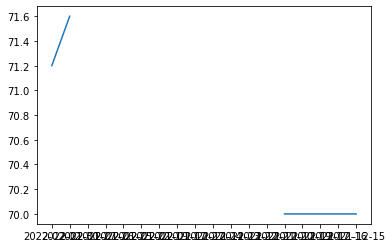

In [37]:
plt.plot(df_morning_ath2.date, df_morning_ath2.poids)

In [34]:
df_morning_ath1.symptomes.value_counts()

[Aucun]                                                                      139
[Maux de tête]                                                                 6
[Douleur et/ou gonflement des seins]                                           1
[Courbatures]                                                                  1
[Aucun, Maux de tête, Fatigue augmentée, Courbatures]                          1
[]                                                                             1
[Aucun, Maux de tête, Fatigue augmentée, Courbatures, Douleurs (crampes)]      1
Name: symptomes, dtype: int64

In [49]:
make_df_timeseries(df_ath1[0:100])

Le dataframe contient 1 séries temporelles différentes, avec au plus 103 points.
Time taken: 0.013210296630859375


,numero_entrainement,type_entrainement,grandeur,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,100
0,1,endurance,altitude,800.6,801.0,800.8,800.8,800.8,800.6,801.6,...,816.4,816.8,817.0,817.0,817.0,817.2,817.2,817.4,817.6,818.0
